# 描述簇的特征

完成细胞状态分群之后，我们的一项基本操作就是鉴定不同细胞群中具有代表性的基因和功能模块，以描述各个簇的状态和功能特征。
描述和鉴定簇的特征可以使用以下一些方法：

* **查找差异基因**，这是其他所有方法的基础，这些基因在某个感兴趣的簇中尤其高或尤其低的表达，得到差异基因之后，你可以直接观察差异基因，并寻找一些标志。对于已经熟知的细胞类型分类而言，通过先验知识手工寻找往往最为方便快捷，然而，先验知识有犯错误的风险
* **基因集富集分析**，使用与已知功能相关的基因集，判断差异基因是否相对于随机分布更加多或少的出现在基因集中，说明该簇的特征与这个基因集的功能注释有关。这提供了一个自动化的注释方法，然而，需要实现确保基因集符合要求。这一类方法包括 ORA，GSEA 和 GSVA，以及最基础的秩序打分方法
* **同源性注释**，如果你研究的物种缺乏良好的基因集注释，或者需要鉴定的细胞类型未被完好定义，你可能可以借用其他物种中的知识。由于演化关系的复杂性，序列同源基因很可能不再从事原有的功能

我们将直接从已整合的数据集加载数据：

In [ ]:
%load_ext autoreload
%autoreload 2

In [8]:
import exprmat as em

# set working directory
em.setwd('/home/data/yangz/shared/tutorial')

### 加载数据集

我们从之前保存的路径加载数据集：

In [9]:
expm = em.load_experiment('expm', load_samples = False)

[!] samples are not dumped in the experiment directory.


In [10]:
expm

integrated dataset of size 14947 × 20899
contains modalities: rna

 modality [rna]
annotated data of size 14947 × 20899
    obs : sample batch group modality taxa barcode ubc n.umi n.genes n.mito n.ribo pct.mito pct.ribo
          filter score.doublet score.doublet.se is.doublet qc leiden
    var : chr start end strand id subtype gene tlen cdslen assembly uid vst.hvg
 layers : ambiguous counts spliced unspliced
   obsm : harmony knn knn.d pca umap
   varm : pca
   obsp : connectivities distances
    uns : leiden leiden.colors neighbors pca umap

[*] samples not loaded from disk.


<exprmat.reader.experiment/39> (2 samples)

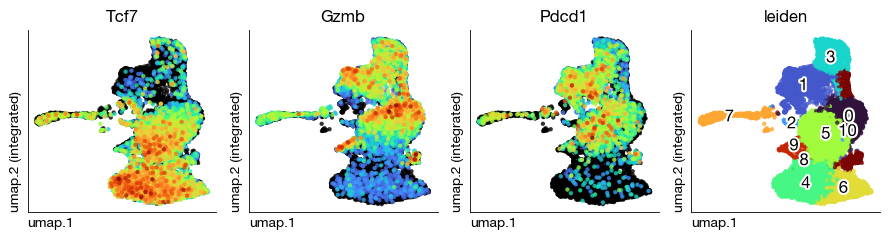

In [11]:
fig = expm.plot_rna_embedding_multiple(
    basis = 'umap', features = ['Tcf7', 'Gzmb', 'Pdcd1', 'leiden'], ncols = 4,
    legend = False, cmap = 'turbo', contour_plot = False,
    annotate = True, annotate_style = 'text',
    sort = True, figsize = (9, 2.5), dpi = 100,
)

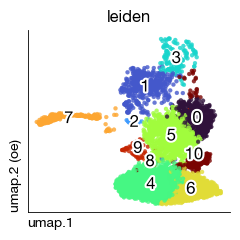

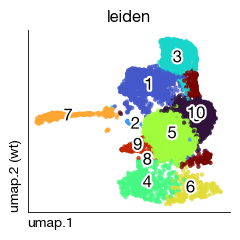

In [12]:
fig = expm.plot_rna_embedding(
    basis = 'umap', color = 'leiden',
    legend = False,
    annotate = True, annotate_style = 'text',
    contour_plot = False,
    sort = True, figsize = (2.5, 2.5), dpi = 100,
    run_on_splits = True, split_key = 'sample', split_selection = ['oe', 'wt']
)

### 寻找聚类差异基因

使用 `rna_markers` 子程序可以获得某亚群细胞相对于其他（或另一个亚群）的差异表达基因

In [13]:
expm.run_rna_markers(
    groupby = 'leiden',
    mask_var = None, 
    groups = ['7'],
    reference = 'rest',
    n_genes = None, rankby_abs = False, pts = True, 
    key_added = 'deg.c7',
    method = 't-test', 
    corr_method = 'benjamini-hochberg',
    tie_correct = False,
    gene_symbol = 'gene',
    layer = 'X'
)

In [14]:
expm.get_rna_markers(
    de_slot = 'deg.c7',
    min_pct = 0.5,
    max_pct_reference = 0.75,
    max_q = 0.05,
    min_lfc = 1.0, max_lfc = 25,
    remove_zero_pval = False
)[['names', 'lfc', 'q', 'pct', 'pct.reference', 'log10.q', 'gene']]

[i] fetched diff `7` over `rest` (77 genes)


,names,lfc,q,pct,pct.reference,log10.q,gene
0,rna:mmu:g49985,9.898786,8.115252e-303,0.963455,0.049146,302.090698,Usp29
1,rna:mmu:g18501,9.046899,1.455132e-263,0.935216,0.043918,262.837097,Atp8a2
2,rna:mmu:g12626,10.268747,1.709545e-225,0.887043,0.011921,224.767120,Gm47689
3,rna:mmu:g10409,9.961272,1.415689e-209,0.868771,0.012339,208.849032,Klhl10
4,rna:mmu:g29588,8.291081,3.461184e-207,0.877076,0.026699,206.460775,Prkg1
...,...,...,...,...,...,...,...
177,rna:mmu:g33961,1.884008,1.420698e-47,0.569767,0.364029,46.847498,Gm14164
191,rna:mmu:g36167,1.690727,4.337659e-46,0.617940,0.476264,45.362745,Rsrc1
199,rna:mmu:g19778,1.694121,1.512243e-45,0.626246,0.510143,44.820378,Zfr
214,rna:mmu:g47916,1.985855,1.289118e-43,0.519934,0.354200,42.889707,Pole4


### 过度表示分析

过度表示分析使用列连表检验某一个基因集是否比随机分布更多的出现在差异基因列表中

In [15]:
expm.run_rna_opa(
    taxa = 'mmu',
    de_slot = 'deg.c7', group_name = None,
    use_abs_lfc = True, min_abs_lfc = 1, max_abs_lfc = 25,
    key_added = 'ora.c7',
    gene_sets = 'bp',
    identifier = 'entrez',
    opa_cutoff = 0.05,
)

[i] fetched diff `7` over `rest`
[i] fetched 6593 genes differentially expressed.
[i] with a background of 18312 observed genes.


[i] retreived 10 terms for plotting.


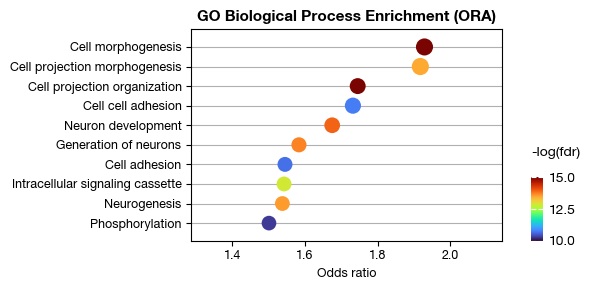

In [22]:
fig = expm.plot_rna_opa_dotplot(
    opa_key = 'ora.c7', max_fdr = 1, max_p = 0.05, 
    top_term = 10, terms = None, # draw all terms
    colour = 'fdr', cmap = 'turbo', figsize = (6, 3), cutoff = 1, ptsize = 5,

    # customizing the formatting rule of the y axis
    formatter = lambda x: x.replace('GOBP_', '').replace('_', ' ').capitalize(),
    title = 'GO Biological Process Enrichment (ORA)'
)

### 基因集富集分析

使用两组间全部基因的对数表达倍率，可以使用一种累积评分法的方式进行富集分析

In [17]:
expm.run_rna_gsea(
    taxa = 'mmu',
    de_slot = 'deg.c7', group_name = None,
    key_added = 'gsea.c7',
    gene_sets = 'kegg',
    identifier = 'entrez'
)

[i] fetched diff `7` over `rest`


2025-09-01 13:59:48,848 [WARNING] Duplicated values found in preranked stats: 0.04% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


[i] fetched 9751 preranked genes by logfc.


In [18]:
expm.get_rna_gsea(gsea_slot = 'gsea.c7')

,name,es,nes,p,fwerp,fdr,tag
3,"Glycine, serine and threonine metabolism",-0.796816,-1.552053,0.000000,0.030,0.027536,13/22
34,Systemic lupus erythematosus,-0.739226,-1.532584,0.000000,0.064,0.029831,21/51
28,Neutrophil extracellular trap formation,-0.714035,-1.498828,0.000000,0.189,0.050942,22/87
10,Primary immunodeficiency,-0.787133,-1.508837,0.001163,0.152,0.052625,4/20
17,Mucin type O-glycan biosynthesis,0.660917,1.672284,0.038217,0.137,0.130208,5/18
4,Steroid hormone biosynthesis,-0.763336,-1.452683,0.008065,0.532,0.154753,9/18
8,Basal transcription factors,0.574968,1.699600,0.000000,0.113,0.156747,3/30
7,Tryptophan metabolism,0.695062,1.769650,0.000000,0.062,0.164211,9/20
1,Carbohydrate digestion and absorption,-0.728645,-1.415909,0.010297,0.800,0.291577,7/22
26,Bile secretion,-0.696115,-1.399678,0.017223,0.884,0.350889,13/32


[i] retreived 10 terms for plotting.


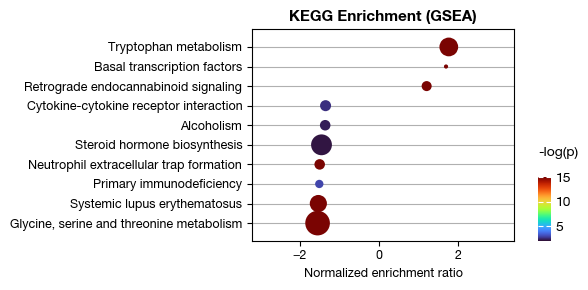

In [23]:
fig = expm.plot_rna_gsea_dotplot(
    gsea_key = 'gsea.c7', max_fdr = 1, max_p = 0.05, 
    top_term = 10, terms = None, # draw all terms
    colour = 'p', cmap = 'turbo', figsize = (6, 3), cutoff = 1, ptsize = 5,

    # customizing the formatting rule of the y axis
    formatter = lambda x: x,
    title = 'KEGG Enrichment (GSEA)'
)

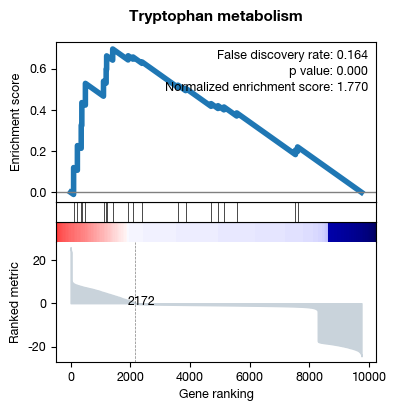

In [21]:
fig = expm.plot_rna_gsea_running_es(
    gsea = 'gsea.c7',
    terms = 'Tryptophan metabolism',
    figsize = (4, 4),
    title = None,
)

### 基因表达量的分组差异

可以在两个分类变量的基础上进行数据集分割，并绘制基因表达量的分组差异

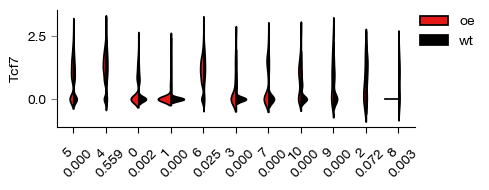

In [24]:
fig = expm.plot_rna_expression_bar(
    gene = 'Tcf7', slot = 'X', group = 'leiden', split = 'sample',
    selected_groups = None, selected_splits = None, palette = ['red', 'black'], 
    figsize = (5, 2), dpi = 100, style = 'violin',
    violin_kwargs = { 'split': True, 'inner': None }
)

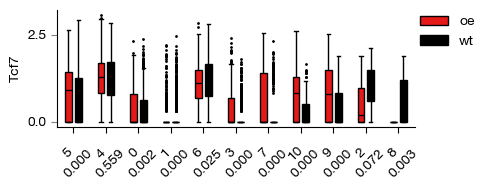

In [25]:
fig = expm.plot_rna_expression_bar(
    gene = 'Tcf7', slot = 'X', group = 'leiden', split = 'sample',
    selected_groups = None, selected_splits = None, palette = ['red', 'black'], 
    figsize = (5, 2), dpi = 100, style = 'box',
    violin_kwargs = { 'split': True, 'inner': None }
)

### 保存数据集

最后保存我们作出的更改

In [26]:
expm

integrated dataset of size 14947 × 20899
contains modalities: rna

 modality [rna]
annotated data of size 14947 × 20899
    obs : sample batch group modality taxa barcode ubc n.umi n.genes n.mito n.ribo pct.mito pct.ribo
          filter score.doublet score.doublet.se is.doublet qc leiden
    var : chr start end strand id subtype gene tlen cdslen assembly uid vst.hvg
 layers : ambiguous counts spliced unspliced
   obsm : harmony knn knn.d pca umap
   varm : pca
   obsp : connectivities distances
    uns : leiden leiden.colors neighbors pca umap deg.c7 ora.c7 gsea.c7

[*] samples not loaded from disk.


<exprmat.reader.experiment/39> (2 samples)

In [27]:
em.memory()

[i] resident memory: 2.27 GiB
[i] virtual memory: 17.91 GiB
